# Simulations

While the main point of `GammaBayes` is an analysis pipeline, as the CTA is currently under construction and for many other reasons the ability to do simulations involving the given models is required. This process is made to be relatively simple and essentially just requires you to define the model in the form of the `DiscreteLogPrior` class and using the `sample` method which gives the 'true' event values, then feed the true events into the `IRF_LogLikelihood` class to add noise representative of the CTA IRFs to get the 'measured' events.

## Simulating True Values

### Setup


For more details on how to construct an instance of the `DiscreteLogPrior` class we recommend looking at the `Probability Classes` tutorial/page.

We first need to define the axes of values that the true event values can take and how many events we wish to simulate for each gamma ray source. It is convenient to store this information in a configuration file, as we have done below.

In [1]:
import numpy as np, time, random

# Printing time so one knows when the script was inspected.
print(time.strftime("%d/%m/%y, %H:%M:%S (Melbourne Time)"))

# Setting seed for consistent results
random.seed(24)

from gammabayes.utils.config_utils import read_config_file



config_file_path = 'ConfigFiles/HyperParameterInference_config.yaml'
config_dict = read_config_file(config_file_path)

04/03/24, 10:08:21 (Melbourne Time)
file path: ConfigFiles/HyperParameterInference_config.yaml


/Users/lpin0002/anaconda3/envs/testofwest/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We then extract these values using the relevant keys. The way the fractions work for determining how many events are given to each component is through what is called a Dirichlet stick breaking process. Essentially one allocates the fraction of events for the first component, then the next fraction dictates how many of the leftover events go to the next component and so on. For more details on this we direct the user to the relevant wikipedia page found [here](https://en.wikipedia.org/wiki/Dirichlet_process#:~:text=The%20stick%2Dbreaking%20process%20is,sample%20from%20a%20Dirichlet%20distribution.).

In [2]:

# source_hyperparameter_input = config_dict['parameter_specifications']
# mixture_bounds               = [config_dict['mixture_fraction_specifications'][mixture]['bounds'] for mixture in config_dict['mixture_fraction_specifications']]

# Extracting the number of total events for this simulation and the stick-breaking fraction for each component
NumEvents                   = config_dict['Nevents']
truemass                    = config_dict['dark_matter_mass']
signal_fraction             = config_dict['signal_fraction']
ccr_of_bkg_fraction         = config_dict['ccr_of_bkg_fraction']
diffuse_of_astro_fraction   = config_dict['diffuse_of_astro_fraction']


# Allocating the number of events for each fraction
nsig = int(round(signal_fraction*NumEvents))
nccr = int(round((1-signal_fraction)*ccr_of_bkg_fraction*NumEvents))
ndiffuse = int(round((1-signal_fraction)*(1-ccr_of_bkg_fraction)*diffuse_of_astro_fraction*NumEvents))
nlocal = int(round((1-signal_fraction)*(1-ccr_of_bkg_fraction)*(1-diffuse_of_astro_fraction)*NumEvents))

# Checking there hasn't been a rounding error
if nsig+nccr+ndiffuse+nlocal!=NumEvents:
    print(nsig, nccr, ndiffuse, nlocal)

assert nsig+nccr+ndiffuse+nlocal==NumEvents


We can then extract the measured and true event value axes with the `GammaBayes` utilities `create_true_axes_from_config` and `create_recon_axes_from_config` which create these axes for the suggested configuration file format.

In [3]:
from gammabayes.utils.config_utils import (
    create_true_axes_from_config, 
    create_recon_axes_from_config, 
)

energy_true_axis,  longitudeaxistrue, latitudeaxistrue       = create_true_axes_from_config(config_dict)
energy_recon_axis, longitudeaxis,     latitudeaxis           = create_recon_axes_from_config(config_dict)


0.2 90.0 100 0.1 -3.05 3.05 -3.0 3.0
0.2 90.0 50 0.2 -3.05 3.05 -3.0 3.0


Then, because the priors within this framework are formulated in the form of the flux of events hitting the CTA, we require access to the effective area of the CTA, contained within the IRFs, and the given `IRF_LogLikelihood` for later will be explained in further detail when relevant. But for now we will say that one has to specify the version of the IRFs (either '3b' or '5' as of time of writing), the hemisphere which is 'South' by default, the pointing direction of the observation (the Galactic Centre by default) and the given true and measured event axes (given as `dependent_axes` and `axes` respectively).

In [4]:
from gammabayes.likelihoods.irfs import IRF_LogLikelihood


irf_loglike = IRF_LogLikelihood(axes   =   [energy_recon_axis,    longitudeaxis,     latitudeaxis], 
                                dependent_axes =   [energy_true_axis,     longitudeaxistrue, latitudeaxistrue],
                                prod_vers='5', ) # or '3b'/3/'3'




Path to irf fits file: /Users/lpin0002/anaconda3/envs/testofwest/lib/python3.12/site-packages/gammabayes/utils/../package_data/irf_fits_files/prod5/CTA-Performance-prod5-v0.1-South-20deg.FITS/Prod5-South-20deg-AverageAz-14MSTs37SSTs.180000s-v0.1.fits.gz

Number of input dimensions 3


Within the standard inference scripts given within `GammaBayes` we also allow one to specify the dark matter model from a configuration file as well under `dark_matter_spectral_model`, we will replicate this behaviour here, but keep in mind you could also just directly use `Z5_ScalarSinglet`.

In [5]:
from gammabayes.dark_matter import CombineDMComps
from gammabayes.dark_matter.density_profiles import Einasto_Profile
from gammabayes.dark_matter.spectral_models import Z2_ScalarSinglet


from gammabayes.utils import (
    dynamic_import
)

from gammabayes.priors import DiscreteLogPrior, log_bkg_CCR_dist, TwoCompPrior
dark_matter_spectral_class = dynamic_import('gammabayes.dark_matter.spectral_models', config_dict['dark_matter_spectral_model'])

We then use the `CombineDMComps` to combine the dark matter spectral and density models giving the default values of parameters that deviate from the class defaults if needed, specifying the `irf_loglike` for it's effective area function, and the true event value axes. 

In [6]:
DM_prior = CombineDMComps(name='Z2 Scalar Singlet dark matter',
                        spectral_class = dark_matter_spectral_class, # or equivalently `Z2_ScalarSinglet,`
                        spectral_class_kwds={'ratios':True,},
                        spatial_class = Einasto_Profile,
                        irf_loglike=irf_loglike, 
                        axes=(energy_true_axis, 
                              longitudeaxistrue, 
                              latitudeaxistrue,), 
                        axes_names=['energy', 'lon', 'lat'],
                        default_spectral_parameters={
                            'mass':config_dict['dark_matter_mass'],}, )

We then have some basic default backgrounds within `GammaBayes`, they either originate from the mis-identification background rate that comes along with the IRFs or are models available through the [`Gammapy`](https://gammapy.org) python package.

In [7]:
ccr_bkg_prior = DiscreteLogPrior(logfunction=log_bkg_CCR_dist, name='CCR Mis-identification Background',
                               axes=(   energy_true_axis, 
                                        longitudeaxistrue, 
                                        latitudeaxistrue,), 
                                    axes_names=['energy', 'lon', 'lat'], )


from gammabayes.priors.astro_sources import FermiGaggeroDiffusePrior, HESSCatalogueSources_Prior
diffuse_astro_bkg_prior = FermiGaggeroDiffusePrior(energy_axis=energy_true_axis, longitudeaxis=longitudeaxistrue, latitudeaxis=latitudeaxistrue, irf=irf_loglike)
point_astro_bkg_prior = HESSCatalogueSources_Prior(energy_axis=energy_true_axis, longitudeaxis=longitudeaxistrue, latitudeaxis=latitudeaxistrue, irf=irf_loglike)


/Users/lpin0002/anaconda3/envs/testofwest/lib/python3.12/site-packages/gammabayes/priors/core/discrete_logprior.py:64: UserWarning: No function to calculate on mesh efficiently given
  warnings.warn('No function to calculate on mesh efficiently given')
/Users/lpin0002/anaconda3/envs/testofwest/lib/python3.12/site-packages/gammabayes/priors/core/discrete_logprior.py:64: UserWarning: No function to calculate on mesh efficiently given
  warnings.warn('No function to calculate on mesh efficiently given')
/Users/lpin0002/anaconda3/envs/testofwest/lib/python3.12/site-packages/gammapy/modeling/models/spatial.py:583: RuntimeWarning: invalid value encountered in multiply
  return u.Quantity(norm * np.exp(exponent).value, "sr-1", copy=False)
/Users/lpin0002/anaconda3/envs/testofwest/lib/python3.12/site-packages/gammabayes/priors/core/discrete_logprior.py:64: UserWarning: No function to calculate on mesh efficiently given
  warnings.warn('No function to calculate on mesh efficiently given')


### Running Simulations

After the above setup, one only needs to provide any given parameters that deviate from the defaults of either the class or the ones explicitly specified and the number of events one wants to simulate using the `sample` method of the `DiscreteLogPrior` class. The output is the `EventData` `GammaBayes` data class, but if you want to, you can extract the main data as a numpy array with `.data` on the class instance, and most of the functions should work without the need for the wrapper.

In [8]:
sig_event_data  = DM_prior.sample(nsig)
ccr_event_data  = ccr_bkg_prior.sample(nccr)
diffuse_event_data  = diffuse_astro_bkg_prior.sample(ndiffuse)
point_event_data  = point_astro_bkg_prior.sample(nlocal)

One of the handy things about the `EventData` wrapper however is the ability to peek/immediately plot the event data.

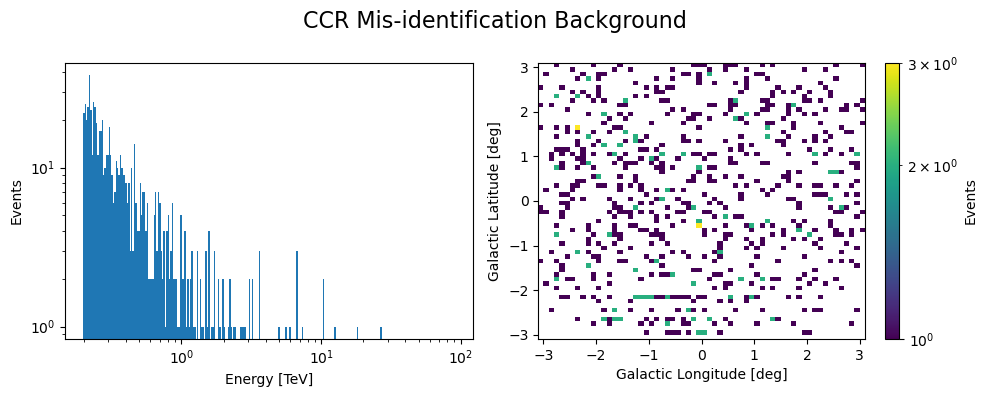

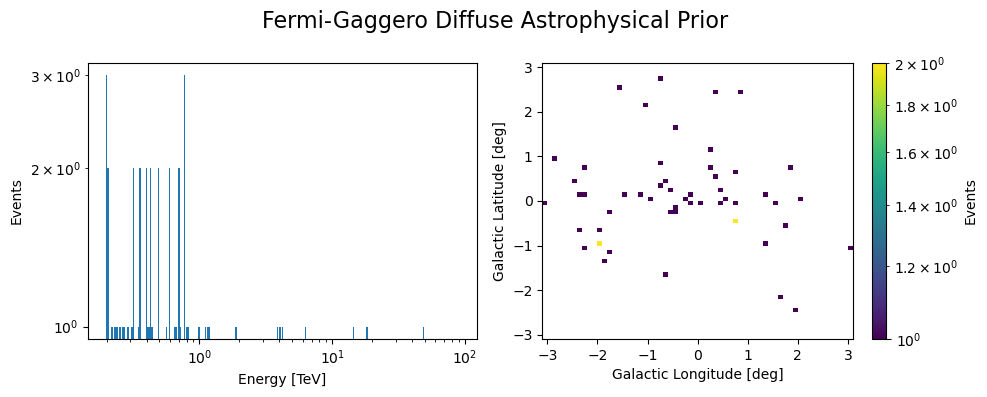

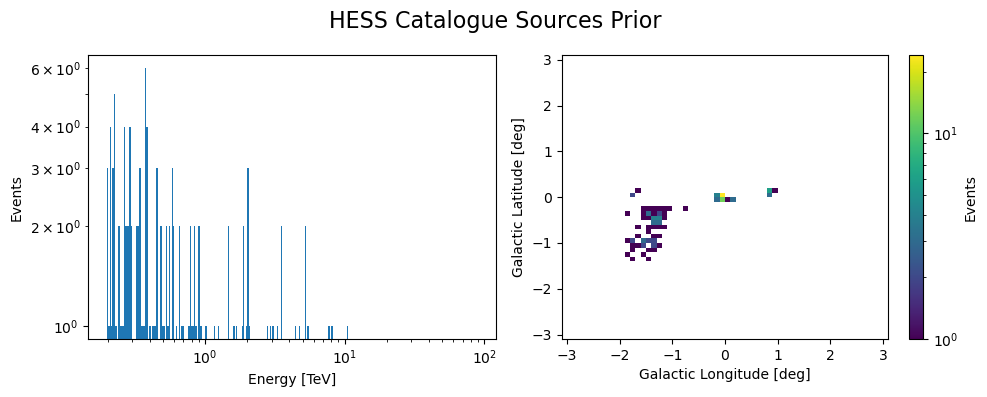

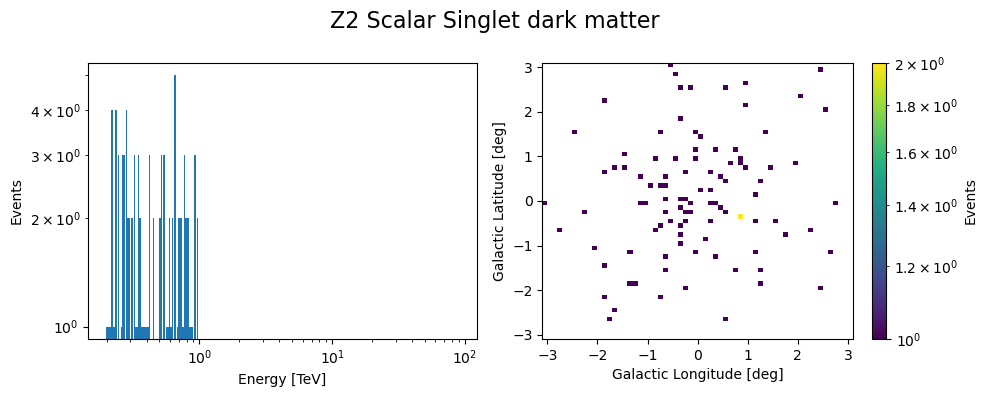

In [9]:
import matplotlib.pyplot as plt

for source_idx, event_data in enumerate([ccr_event_data, diffuse_event_data, point_event_data, sig_event_data]):
   
    fig, ax = event_data.peek()
    plt.suptitle(np.unique(event_data._source_ids)[0], size=16)
    plt.tight_layout()
    plt.show()

One can then combine these via the append or `+` methods.

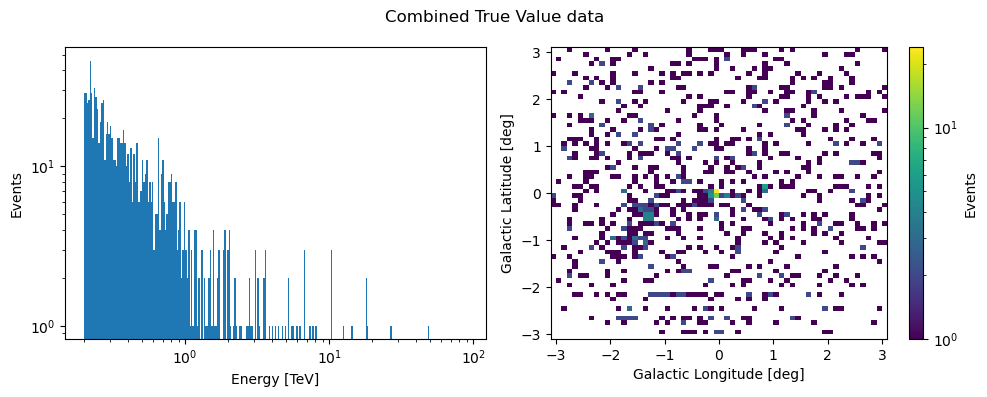

In [10]:
true_events = sig_event_data+ccr_event_data+diffuse_event_data+point_event_data

true_events.peek()
plt.suptitle("Combined True Value data")
plt.tight_layout()
plt.show()


## Measured Value Simulations

Once you has the true event values, all you have to do is create an instance of the `IRF_LogLikelihood` class, and use the given `sample` method, that will iterate through the true event values, construct the relevant discrete probabilities for given true value about the measured event value axes, and then sample the probability density to get 'measured' event values that are effectively the true event values with added noise that is representative of the IRFs.

In [11]:
from gammabayes.likelihoods.irfs import IRF_LogLikelihood


irf_loglike = IRF_LogLikelihood(axes   =   [energy_recon_axis,    longitudeaxis,     latitudeaxis], 
                                dependent_axes =   [energy_true_axis,     longitudeaxistrue, latitudeaxistrue],
                                prod_vers='5', ) # or '3b'/3/'3'




Path to irf fits file: /Users/lpin0002/anaconda3/envs/testofwest/lib/python3.12/site-packages/gammabayes/utils/../package_data/irf_fits_files/prod5/CTA-Performance-prod5-v0.1-South-20deg.FITS/Prod5-South-20deg-AverageAz-14MSTs37SSTs.180000s-v0.1.fits.gz

Number of input dimensions 3


In [12]:
# Might take a few minutes (<~11min)
measured_event_data = irf_loglike.sample(true_events)

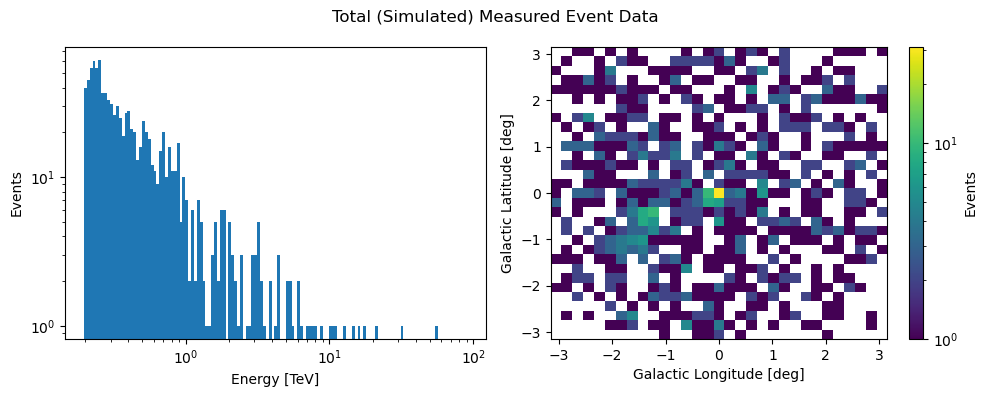

In [13]:
measured_event_data.peek()
plt.suptitle("Total (Simulated) Measured Event Data")
plt.tight_layout()
plt.show()

We will save these values for later use in the `Hyperparameter Inference` tutorial. The method for loading said data is also below but commented out for reference.

In [14]:
measured_event_data.save("tutorial_data/measured_data.h5", writemethod='w')

# To load uncomment
# from gammabayes import EventData
# EventData.load("measured_data.h5")